In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import glob
import os

In [2]:
pd.set_option('mode.use_inf_as_na', True)

In [3]:
train_df = pd.read_csv("data/twitter_data_train.csv")
test_df = pd.read_csv("data/twitter_data_test.csv")

print(train_df.shape)
print(test_df.shape)

(9445, 233)
(1667, 233)


In [4]:
to_drop = [
    'account_type', 
    'id', 
    'name', 
    'screen_name',
    'profile_image_url',
    'protected',
    'verified',
    'description',
    'description_processed',
    'tweets_list',
    'tweets_list_processed',
    'url'
    ]

X_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type']
X_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type']

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [5]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

#### Logistic Regression model Training and Hyper parameters tuning

In [37]:
LRModel = LogisticRegression(max_iter = 200000)
LRModel.fit(X_train, y_train)
# Train set
LRModel_train_score = LRModel.score(X_train, y_train)
print('Train Set Accuracy Score: ', LRModel_train_score)
pred = LRModel.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred))
print("Train Set",classification_report(y_train, pred))

area_under_curve_train = metrics.roc_auc_score(y_train, pred)
print("Area Under Curve:", area_under_curve_train)

#Test Set
LRModel_test_score = LRModel.score(X_test, y_test)
print('Test Set Accuracy Score: ', LRModel_test_score)
test_pred = LRModel.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred))
print("Test Set",classification_report(y_test, test_pred))

area_under_curve_test = metrics.roc_auc_score(y_test, test_pred)
print("Area Under Curve:", area_under_curve_test)

Train Set Accuracy Score:  0.9612493382742192
Train Set Confusion Matrix 
 [[6867  137]
 [ 229 2212]]
Train Set               precision    recall  f1-score   support

           0       0.97      0.98      0.97      7004
           1       0.94      0.91      0.92      2441

    accuracy                           0.96      9445
   macro avg       0.95      0.94      0.95      9445
weighted avg       0.96      0.96      0.96      9445

Area Under Curve: 0.9433128690318239
Test Set Accuracy Score:  0.9514097180563887
Test Set Confusion Matrix 
 [[1202   32]
 [  49  384]]
Test Set               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1234
           1       0.92      0.89      0.90       433

    accuracy                           0.95      1667
   macro avg       0.94      0.93      0.94      1667
weighted avg       0.95      0.95      0.95      1667

Area Under Curve: 0.9304520495132148


C:\Users\radellng\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
#define models and parameters for Logistic Regression
#estimate 1 hour to do tuning
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1','l2']
c_values = 10. ** np.arange(-3,8)

#define grid seach
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

#results 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#Best: 0.982107 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best: 0.982107 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.975613 (0.004766) with: {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}
0.911064 (0.007096) with: {'C': 0.001, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'none', 'solver': 'liblinear'}
0.704080 (0.070334) with: {'C': 0.001, 'penalty': 'none', 'solver': 'sag'}
0.685834 (0.071493) with: {'C': 0.001, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'lbfgs'}
0.913605 (0.006372) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'sag'}
0.685870 (0.071486) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
0.939827 (0.006217) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.910922 (0.006754) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.91

#### Testing 

In [7]:
print(X_test.shape)
print(y_test.shape)

(1667, 221)
(1667,)


In [36]:
best_model = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
best_model.fit(X_train, y_train)
# Train set
best_model_train_score = best_model.score(X_train, y_train)
print('Train Set Accuracy Score after tuning: ', best_model_train_score)
pred1 = best_model.predict(X_train)
print("Train Set Confusion Matrix \n", confusion_matrix(y_train, pred1))
print("Train Set",classification_report(y_train, pred1))

area_under_curve_train = metrics.roc_auc_score(y_train, pred1)
print("Area Under Curve after tuning:", area_under_curve_train)

#Test Set
best_model_test_score = best_model.score(X_test, y_test)
print('Test Set Accuracy Score: ', best_model_test_score)
test_pred1 = best_model.predict(X_test)
print("Test Set Confusion Matrix \n", confusion_matrix(y_test, test_pred1))
print("Test Set",classification_report(y_test, test_pred1))

area_under_curve_test = metrics.roc_auc_score(y_test, test_pred1)
print("Area Under Curve:", area_under_curve_test)

Train Set Accuracy Score after tuning:  0.9849655902593965
Train Set Confusion Matrix 
 [[6939   65]
 [  77 2364]]
Train Set               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7004
           1       0.97      0.97      0.97      2441

    accuracy                           0.98      9445
   macro avg       0.98      0.98      0.98      9445
weighted avg       0.98      0.98      0.98      9445

Area Under Curve after tuning: 0.9795875699050416
Test Set Accuracy Score:  0.976004799040192
Test Set Confusion Matrix 
 [[1214   20]
 [  20  413]]
Test Set               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1234
           1       0.95      0.95      0.95       433

    accuracy                           0.98      1667
   macro avg       0.97      0.97      0.97      1667
weighted avg       0.98      0.98      0.98      1667

Area Under Curve: 0.9688015840635422


Total number of correct predictions: TP + TN = 1628 out of 1667 data points

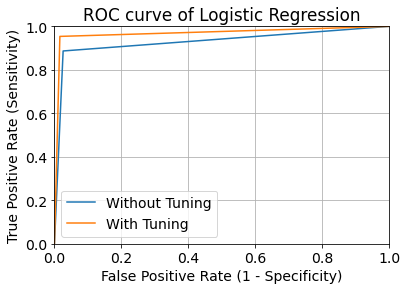

In [41]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
plt.plot(fpr, tpr, label = "Without Tuning")
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_pred1)
plt.plot(fpr1, tpr1, label = "With Tuning")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 14
plt.title('ROC curve of Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)